# Postmodel Analysis

This notebook will guide the `triage` user through some useful rutines to compare individual models across `model_group_id`'s. This is an interactive process that combines huntches and some general ways to compare 
models. Before starting this process, is important to run `triage`'s _Audition_ component which will filter
`model_group_id`'s using user-defined metrics (see [Audition](https://github.com/dssg/triage/blob/master/src/triage/component/audition/Audition_Tutorial.ipynb) to explore more). 

In [1]:
import pandas as pd
from utils.test_conn import db_engine
from evaluator import get_models_ids, Model
from group_evaluator import ModelGroup
from matplotlib import pyplot as plt

/mnt/data/users/ihiguera/triage/triage_env/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


### 1. Load audited models in a list
Audition will output a dict object with a set of models for each of the defined metrics. We can either read from Audition output, or we can define a list (`audited_models`) to start the post-modeling exploration. We will get each individual `model_id` from the audited `model_groups_id`'s and get the relevant metadata and matrices for each models using the `Model` class. 

In [3]:
# List the audited model groups
audited_models = [19,43,55]

# Get models_ids tuples from selected model_group_ids
list_tuple_models = get_models_ids(audited_models)

# Use Model class object and retrieve indiviual model metadata
l_t = [Model(i.model_group_id, i.model_id) for i in list_tuple_models]

In [3]:
len(l_t)

9

We can explore each of the model class attributes:

In [4]:
print(l_t[0])

Model object for model_id: 44
 Model Group: 19
 Model type: sklearn.ensemble.RandomForestClassifier
 Model hyperparameters: {'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 'sqrt', 'n_estimators': 1000, 'min_samples_leaf': 1, 'min_samples_split': 50}\Matrix hashes (train,test): ['936d9a0559092efbde15043d36b557a0', '8a2f41920a5b27466c278751f7643b50']


Or we can explore all our models:

In [6]:
model_df = pd.DataFrame([model.__dict__ for model in l_t])
model_df = model_df.loc[:, ['model_group_id', 'model_id', 'model_type', 'hyperparameters', 'train_matrix_uuid']].sort_values(['model_group_id'])
pd.concat([model_df.drop(['hyperparameters'], axis=1), model_df['hyperparameters'].apply(pd.Series)], axis=1)

,model_group_id,model_id,model_type,train_matrix_uuid,criterion,class_weight,max_features,n_estimators,min_samples_leaf,min_samples_split
0,19,44,sklearn.ensemble.RandomForestClassifier,936d9a0559092efbde15043d36b557a0,gini,balanced,sqrt,1000,1,50
3,19,86,sklearn.ensemble.RandomForestClassifier,d1abe0f61726575979c2194390af8ba3,gini,balanced,sqrt,1000,1,50
6,19,128,sklearn.ensemble.RandomForestClassifier,02a250d1df77a98b8979bdfb656d029a,gini,balanced,sqrt,1000,1,50
1,43,68,sklearn.ensemble.RandomForestClassifier,a4310fc069672a3df46a618d2acd8c43,gini,balanced,sqrt,1000,1,50
4,43,110,sklearn.ensemble.RandomForestClassifier,c7450a6c72ff1b067a5d30e78b47c080,gini,balanced,sqrt,1000,1,50
7,43,152,sklearn.ensemble.RandomForestClassifier,4b09c67e31e6a0cba9f99aef600967c2,gini,balanced,sqrt,1000,1,50
2,55,80,sklearn.ensemble.RandomForestClassifier,27064e1288bbd8d0fd712af48269364a,gini,balanced,sqrt,1000,1,50
5,55,122,sklearn.ensemble.RandomForestClassifier,e9280b7305e1eb070484dcb8c88a0ee2,gini,balanced,sqrt,1000,1,50
8,55,164,sklearn.ensemble.RandomForestClassifier,74faccd22f6762218a0a432dec469a79,gini,balanced,sqrt,1000,1,50


Some of the attributes are defined as `None` by default due to memory and efficiency constraints. To load _heavy_ matrices and predictions we have different methods to do so. The `load_features_preds_matrix` and `load_train_matix` methods are helpful options that will retrieve matrices from either AWS S3 or local files (depending on the `path` argument, the function will use the rigth approach). 

## 2. Individual model exploration

We can split the model exploration in several steps: 
   1. Predicted labels distribution
   2. Features importances
   3. Model Metrics

### 1. Score/Label Distributions

We can first give a intuitive description of the classification by ploting how the score distributes across the predicted labels. You can change some attributes of the plots: 
 - `figsize`: changes the object size passed to matplotlib
 - `fontsize`: changes the fontsize passed to axes, legends and title
 - `label_names`: changes the label arguments.
 
Check the Method definition for more options

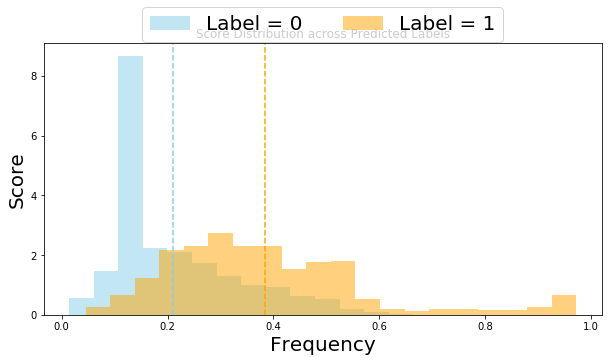

In [7]:
l_t[1].plot_score_label_distributions(figsize=(10,5))

We can check the score behavior across a specific feature (loading the prediction matrix first)

In [15]:
l_t[0].load_features_preds_matrix('/mnt/data/users/ihiguera/dirtyduck/triage/output/matrices/')

#### 2. Features importances

We can extract individual feature importances from `triage` results schema and indentify the important features for each model. In this `dirtyduck` example, we find that the feature score for importance has a bi-modal behavior, which persists even when removing the features with 0 importance value. 


We can also plot the top-10 features by importance

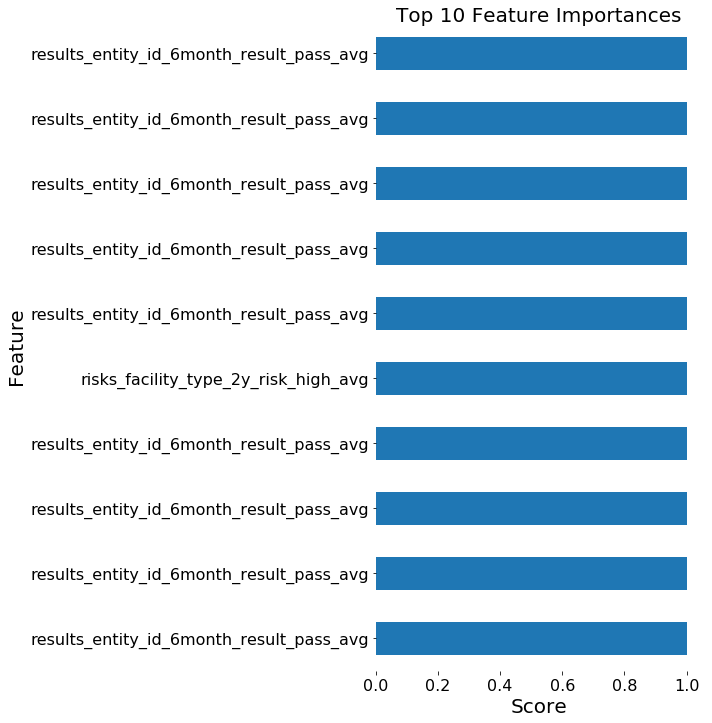

In [9]:
l_t[0].plot_feature_importances(n_features=10, figsize=(10,10))

This example is particularly not very informative since the feature importances are not well distributed. If we take a close look to the feature importances attribute of out model (using the `Model.feature_importances`), we can check how the scores are distributed. To do this we will use `pandas` built-in plots (not nice).

Text(0.5,1,'Feature importances distribution')

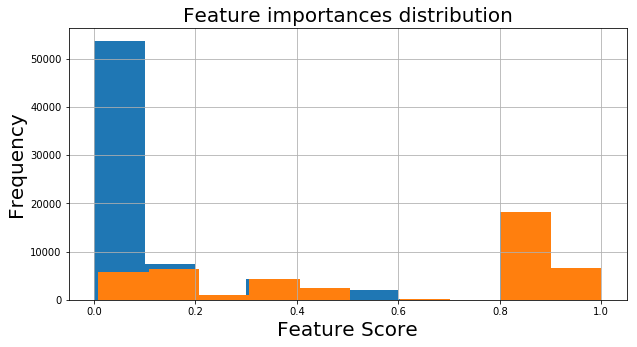

In [10]:
f_importances = l_t[0].feature_importances
f_importances_no_zeros = f_importances[f_importances.feature_value > 0]

fig, ax = plt.subplots(figsize=(10, 5))
l_t[0].feature_importances['feature_value'].hist()
f_importances_no_zeros['feature_value'].hist()
ax.set_ylabel('Frequency', fontsize=20)
ax.set_xlabel('Feature Score', fontsize=20)
plt.title('Feature importances distribution', fontsize=20)

### 3. Model Metrics

The `Model` class include some handy methods/wrappers to plot `sklearn` metrics to assess some common model metrics: AUC, ROC Curves, Precision vs. Recall, and others: 

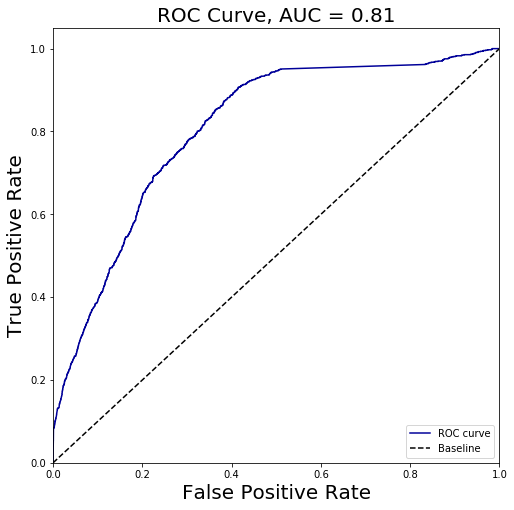

In [11]:
l_t[0].plot_ROC(figsize=(8,8))

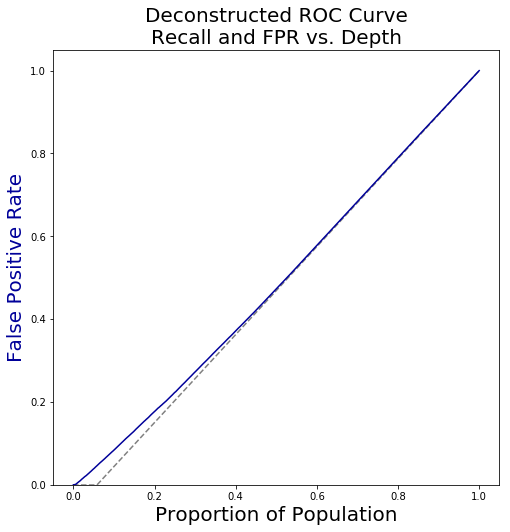

In [12]:
l_t[0].plot_recall_fpr_n(figsize=(8,8))

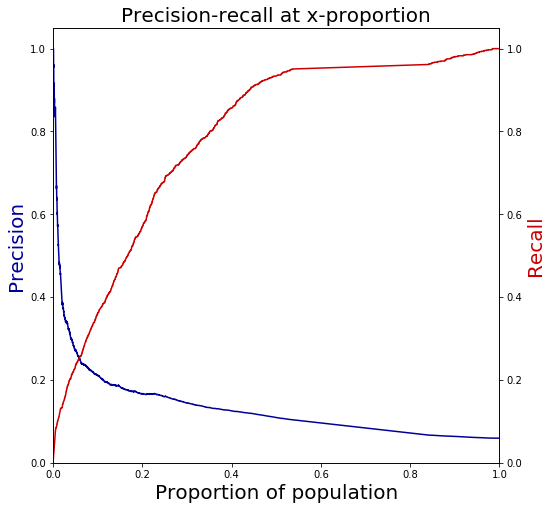

In [12]:
l_t[0].plot_precision_recall_n(figsize=(8,8))

## 3. Model Group Exploration (and across all models)

We can define a `ModelGroup` class object where we store all the data for all the selected models and make comparisons easier. We have some basic methods that can serve us to compare methods. This works as a batch of individual `model_id` and we can compare between them.

TO-DO:
 - Jaccard 
 - Spearman correlation for features and top-k entities
 - Error analysis (decision trees with $ \hat y - y$)

In [4]:
audited_models_class = ModelGroup(tuple(audited_models))

We can check the contents of the `ModelGroup` class.

In [5]:
print(audited_models_class)

Model collection object for model_ids: [152, 80, 44, 68, 122, 110, 164, 86, 128]
 Model Groups: (19, 43, 55)
 Model types: ['sklearn.ensemble.RandomForestClassifier', 'sklearn.ensemble.RandomForestClassifier', 'sklearn.ensemble.RandomForestClassifier', 'sklearn.ensemble.RandomForestClassifier', 'sklearn.ensemble.RandomForestClassifier', 'sklearn.ensemble.RandomForestClassifier', 'sklearn.ensemble.RandomForestClassifier', 'sklearn.ensemble.RandomForestClassifier', 'sklearn.ensemble.RandomForestClassifier']
 Model hyperparameters: [{'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 'sqrt', 'n_estimators': 1000, 'min_samples_leaf': 1, 'min_samples_split': 50}, {'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 'sqrt', 'n_estimators': 1000, 'min_samples_leaf': 1, 'min_samples_split': 50}, {'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 'sqrt', 'n_estimators': 1000, 'min_samples_leaf': 1, 'min_samples_split': 50}, {'criterion': 'gini', 'class_

In [6]:
audited_models_class.model_id

[152, 80, 44, 68, 122, 110, 164, 86, 128]

In [7]:
audited_models_class.train_end_time

[Timestamp('2018-01-13 00:00:00'),
 Timestamp('2016-01-13 00:00:00'),
 Timestamp('2016-01-13 00:00:00'),
 Timestamp('2016-01-13 00:00:00'),
 Timestamp('2017-01-13 00:00:00'),
 Timestamp('2017-01-13 00:00:00'),
 Timestamp('2018-01-13 00:00:00'),
 Timestamp('2017-01-13 00:00:00'),
 Timestamp('2018-01-13 00:00:00')]

### 1. Jaccard Similarity
We can compare models using the overlap between entity predictions

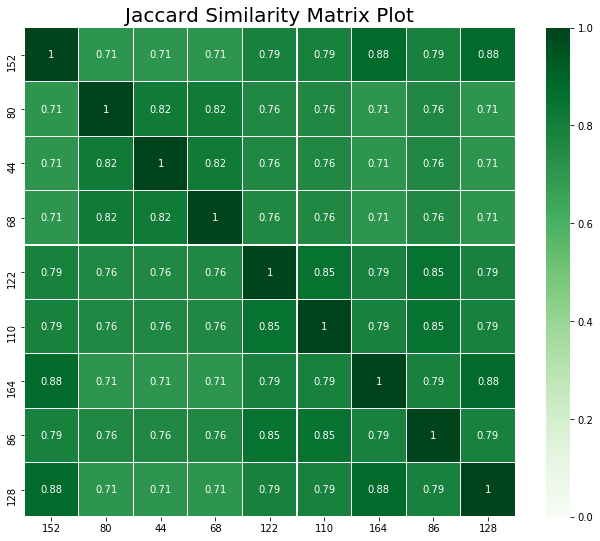

In [13]:
audited_models_class.plot_jaccard(figsize=(11,9))

We can restrict Jaccard Similarity for only a set of comparable models in time

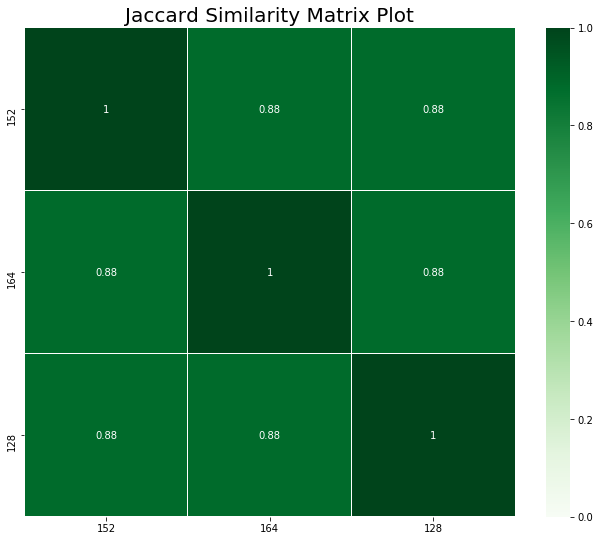

In [16]:
audited_models_class.plot_jaccard(figsize=(11,9), 
                                  model_subset=[152, 164, 128],
                                   top_n = 100)